# Data Generation Process for Computation Graph Task

In [1]:
import numpy as np
import string
import random

In [2]:
n_funcs = 10 # number of functions
mod_val = 16 # modulo value for numeric values

func_vocab = [f'func{i}' for i in range(1, n_funcs+1)]
var_vocab = list(string.ascii_lowercase) # letters a-z
operand_vocab = [',', '(', ')', '+', '-', '*', '/']
numeric_vocab = [str(i) for i in range(mod_val)]

vocab = operand_vocab + func_vocab + var_vocab  + numeric_vocab

In [3]:
# a naive way to randomly sample a computation graph

def sample_computation_graph_prompt(n_vars, func_degree, verbose=False):

    # first, sample a topological order of variables for computation DAG
    var_top_order = list(np.random.choice(var_vocab, size=n_vars, replace=False))

    edges = [] # for storing edges in DAG
    func_annotations = dict() # for storing function annotations for each variable
    prompt = [] # for storing prompt

    if verbose:
        print(f'topological order of variables in DAG: {var_top_order}')

    for idx, var in enumerate(var_top_order):
        # check if leaf node
        if idx < func_degree: # for now, first func_degree variables are leaf nodes (because too few possible parents)
            var_val = np.random.choice(numeric_vocab)
            edges.append((var_val, var))
            func_annotations[var] = "leaf value assignment"
            prompt += [var_val, '->', var, ';']
            if verbose:
                print(f'{var} <- {var_val}')
        # if not leaf node, parents are randomly chosen from preceeding variables (wrt topological order)
        # node is a randomly-selected function of its parents
        else:
            # randomly sample parents from preceeding variables
            parents = np.random.choice(var_top_order[:idx], size=func_degree, replace=False).tolist()

            # randomly sample function
            func = np.random.choice(func_vocab)
            func_annotations[var] = func

            for parent in parents:
                edges.append((parent, var))

            prompt += [func, '('] + list(','.join(parents)) + [')'] + ['->', var, ';']

            if verbose:
                print(f'{var} <- {func}({", ".join(parents)})')

    if verbose:
        print()
        print(f"prompt: {' '.join(prompt)}")

    return dict(prompt=prompt, edges=edges, func_annotations=func_annotations, var_top_order=var_top_order)

In [4]:
n_vars = 6
func_degree = 2 # for now, all functions have same degree

sample = sample_computation_graph_prompt(n_vars, func_degree, verbose=True)
prompt, edges, func_annotations, var_top_order = sample['prompt'], sample['edges'], sample['func_annotations'], sample['var_top_order']

topological order of variables in DAG: ['c', 'w', 'j', 'u', 'q', 'p']
c <- 0
w <- 15
j <- func5(w, c)
u <- func6(c, w)
q <- func10(j, w)
p <- func7(j, c)

prompt: 0 -> c ; 15 -> w ; func5 ( w , c ) -> j ; func6 ( c , w ) -> u ; func10 ( j , w ) -> q ; func7 ( j , c ) -> p ;


is DAG: True


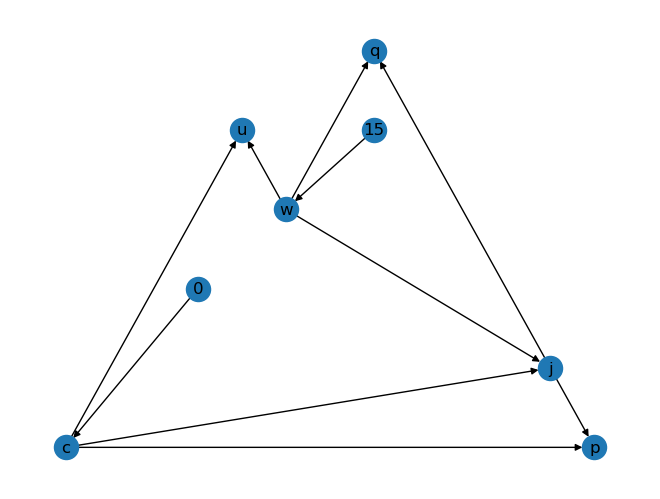

In [5]:
# draw
import networkx as nx

G = nx.from_edgelist(edges, create_using=nx.DiGraph)
print(f'is DAG: {nx.is_directed_acyclic_graph(G)}')

nx.draw_planar(G, with_labels=True)

In [6]:
import matplotlib.pyplot as plt

In [7]:
# draw DAG according to topological order

def draw_topological_order(G, top_order, rad=-0.8, figsize=(8,4), orientation='horizontal'):
    numeric_nodes = [node for node in G.nodes() if node in numeric_vocab]
    top_order = numeric_nodes + top_order

    if orientation == 'horizontal':
        pos = {node:(top_order.index(node),0) for node in G.nodes()}
    else:
        pos = {node:(0,top_order.index(node)) for node in G.nodes()}

    fig, ax = plt.subplots(figsize=figsize)
    for edge in G.edges():
        source, target = edge
        rad = 0.8
        rad = rad if top_order.index(source)%2 else -rad
        ax.annotate("",
                    xy=pos[source],
                    xytext=pos[target],
                    arrowprops=dict(arrowstyle="->", color="black",
                                    connectionstyle=f"arc3,rad={rad}",
                                    alpha=0.6,
                                    linewidth=1.5))
    nx.draw_networkx_nodes(G, pos=pos, node_size=500, node_color='black')
    nx.draw_networkx_labels(G, pos=pos, font_color='white')
    plt.box(False)
    return fig, ax


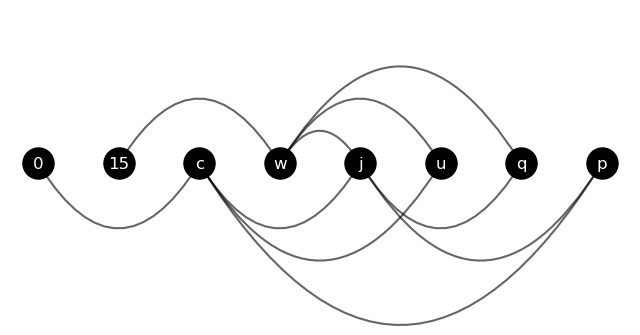

In [8]:
fig, ax = draw_topological_order(G, var_top_order)

In [9]:
# generate prompt from graph